In [1]:
# Imports libraries
import torch
import torchvision
import numpy as np
import random

import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [3]:
# Load the MNIST training and testing datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

In [4]:
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [5]:
# Create data loaders for easy batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

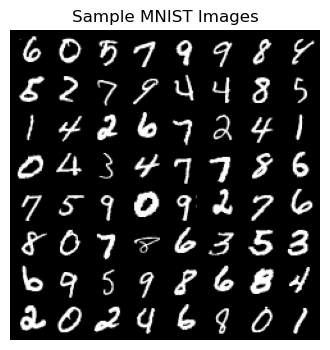

In [ ]:
images, labels = next(iter(train_loader))

# Create a grid of images (8x8) for display
grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)

# Display the images in a grid
plt.figure(figsize=(4, 8))
plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
plt.axis('off')
plt.title("Sample MNIST Images")
plt.show()


In [7]:
# Extract labels from the dataset
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

# Count occurrences of each label
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Display the counts
print("Training Label Counts:", train_label_counts)
print("Testing Label Counts:", test_label_counts)

Training Label Counts: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Testing Label Counts: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [8]:
# Step 1: Extract indices of all samples with label 1
label_1_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]

# Step 2: Define the split ratio and split indices for fine-tune and remaining data
fine_tune_ratio = 0.1  # Adjust this ratio as needed
fine_tune_count = int(fine_tune_ratio * len(label_1_indices))

# Shuffle indices for randomness

random.shuffle(label_1_indices)

# Split label 1 indices into fine-tune and remaining sets
fine_tune_indices = label_1_indices[:fine_tune_count]
remaining_indices = label_1_indices[fine_tune_count:] + [i for i, (_, label) in enumerate(train_dataset) if label != 1]

# Step 3: Create separate subsets for fine-tuning and remaining data
fine_tune_data = [train_dataset[i] for i in fine_tune_indices]  # Store actual data
remaining_data = Subset(train_dataset, remaining_indices)

In [9]:
# Step 1: Define the ratio for training and testing (80% train, 20% test)
train_size = int(0.8 * len(remaining_data))  # 80% of remaining data for training
test_size = len(remaining_data) - train_size  # 20% for testing

# Step 2: Split the remaining_data into training and testing datasets
train_data, test_data = random_split(remaining_data, [train_size, test_size])

# Step 3: Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Step 1: Define the Model
First, let's define a simple fully connected neural network (FCNN) for digit classification:

In [10]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

# Initialize the model
model = SimpleNN()

### Step 2: Define the Loss Function and Optimizer
Now, we will define the loss function and optimizer. Since this is a classification problem, we will use CrossEntropyLoss, and for optimization, we'll use the Adam optimizer:

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Step 3: Training the Model
Next, let's train the model using the train_loader:

In [14]:
# Set the model to training mode
model.train()

# Training loop
num_epochs = 10  # Adjust the number of epochs based on your requirements

for epoch in range(num_epochs):
    running_loss = 0.0

    # Create a progress bar for the current epoch
    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track the running loss
            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
            pbar.update(1)

# Final newline to avoid progress bar overlap with other outputs
print("Training complete!")


Epoch [10/10]: 100%|██████████| 742/742 [00:11<00:00, 64.91batch/s, Loss=0.0431]

Training complete!


### Step 4: Evaluate the Model
Once the model is trained, you can evaluate it on the test set:

In [15]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the predictions and true labels
all_predictions = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in train_loader:
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels for metric calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cr = classification_report(all_labels, all_predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Classification report for tain data:\n{cr}')


Classification report for tain data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4734
           1       0.99      1.00      0.99      4872
           2       0.99      0.99      0.99      4795
           3       0.97      0.99      0.98      4846
           4       0.99      1.00      0.99      4674
           5       1.00      0.95      0.98      4369
           6       1.00      0.99      0.99      4741
           7       1.00      0.97      0.98      4979
           8       0.97      0.99      0.98      4679
           9       0.96      0.99      0.98      4771

    accuracy                           0.99     47460
   macro avg       0.99      0.98      0.99     47460
weighted avg       0.99      0.99      0.99     47460



In [16]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the predictions and true labels
all_predictions = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels for metric calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cr = classification_report(all_labels, all_predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Classification report for test data:\n{cr}')


Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1189
           1       0.97      1.00      0.98      1196
           2       0.97      0.96      0.96      1163
           3       0.96      0.97      0.97      1285
           4       0.97      0.98      0.98      1168
           5       0.99      0.94      0.96      1052
           6       0.99      0.98      0.98      1177
           7       0.99      0.95      0.97      1286
           8       0.95      0.97      0.96      1172
           9       0.92      0.97      0.95      1178

    accuracy                           0.97     11866
   macro avg       0.97      0.97      0.97     11866
weighted avg       0.97      0.97      0.97     11866



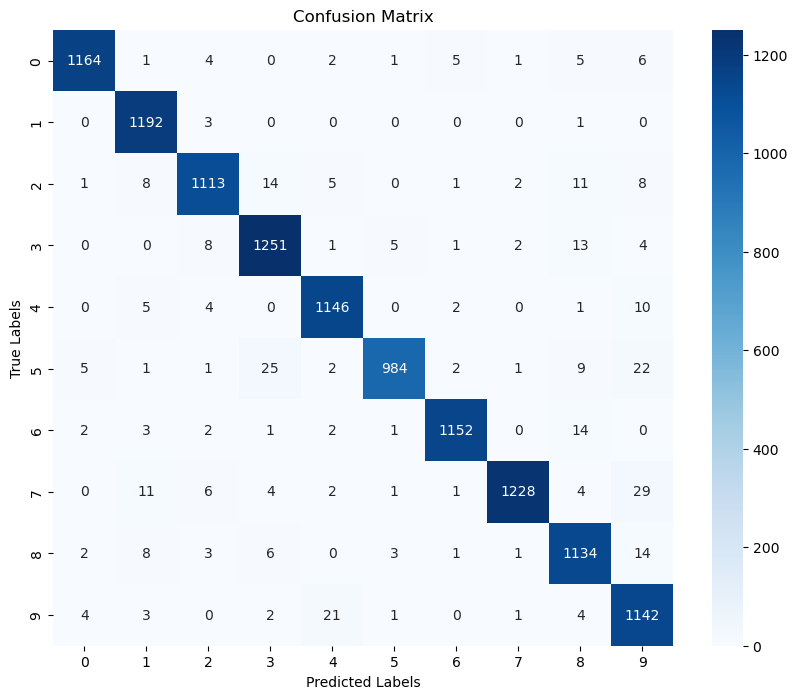

In [17]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [18]:
# Save the model
torch.save(model.state_dict(), 'predefined_model.pth')

print("Model saved successfully!")

Model saved successfully!


## Spliting finetuned data

In [19]:
# Step 1: Define the ratio for training and testing (80% train, 20% test)
train_size = int(0.8 * len(fine_tune_data))  # 80% of remaining data for training
test_size = len(fine_tune_data) - train_size  # 20% for testing

# Step 2: Split the remaining_data into training and testing datasets
train_data, test_data = random_split(fine_tune_data, [train_size, test_size])

# Step 3: Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Verify the split
print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))

Training data size: 539
Testing data size: 135


## Training

In [20]:
# Global variables to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Set the model to training mode
model.train()

# Training loop
num_epochs = 10  # Adjust the number of epochs based on your requirements

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Create a progress bar for the current epoch
    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track the running loss
            running_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Update the progress bar
            pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
            pbar.update(1)

    # Calculate and store training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop (optional, set model to evaluation mode)
    model.eval()  # Set to evaluation mode to disable dropout/batchnorm, if any
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate and store validation loss and accuracy
    val_loss = val_running_loss / len(train_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Final message
print("Training complete!")


Epoch [1/10]: 100%|██████████| 9/9 [00:00<00:00, 120.49batch/s, Loss=0.0362]


Epoch [1/10] - Train Loss: 0.0362, Train Accuracy: 99.26%, Validation Loss: 0.0084, Validation Accuracy: 99.81%


Epoch [2/10]: 100%|██████████| 9/9 [00:00<00:00, 99.15batch/s, Loss=0.0063] 


Epoch [2/10] - Train Loss: 0.0063, Train Accuracy: 99.81%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [3/10]: 100%|██████████| 9/9 [00:00<00:00, 288.85batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [4/10]: 100%|██████████| 9/9 [00:00<00:00, 270.84batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [5/10]: 100%|██████████| 9/9 [00:00<00:00, 319.14batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [6/10]: 100%|██████████| 9/9 [00:00<00:00, 316.57batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [7/10]: 100%|██████████| 9/9 [00:00<00:00, 323.93batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [8/10]: 100%|██████████| 9/9 [00:00<00:00, 320.18batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [9/10]: 100%|██████████| 9/9 [00:00<00:00, 316.11batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%


Epoch [10/10]: 100%|██████████| 9/9 [00:00<00:00, 310.48batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Training complete!


In [21]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the predictions and true labels
all_predictions = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in train_loader:
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels for metric calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cr = classification_report(all_labels, all_predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Classification report for tain data:\n{cr}')


Classification report for tain data:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       539

    accuracy                           1.00       539
   macro avg       1.00      1.00      1.00       539
weighted avg       1.00      1.00      1.00       539



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [122]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the predictions and true labels
all_predictions = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels for metric calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cr = classification_report(all_labels, all_predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Classification report for tain data:\n{cr}')


Classification report for tain data:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       135

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


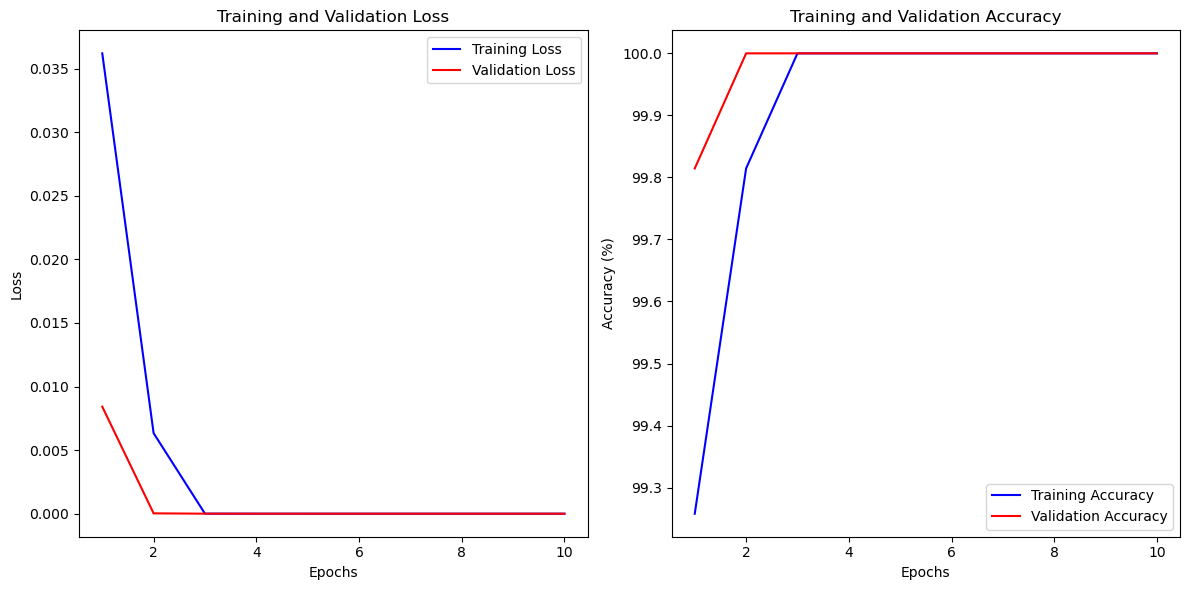

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
epochs = range(1, num_epochs + 1)

# Training and Validation Loss Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [23]:
# Save the model
torch.save(model.state_dict(), 'finetuned_model.pth')

print("Model saved successfully!")

Model saved successfully!
